Diego García Maroto (diegar20@ucm.com)

# Parte 2: Mapas de regresión
Toma tus índices de extremos de las diferentes regiones (Norte, Sur, Este, Oeste y Centro)
y en las estaciones que crees que tienen mayor variabilidad y calcula el mapa de regresión
con las anomalías de SST en el Pacífico y con la SLP en el Atlántico. En el caso de las SST
del Pacífico, realiza los mapas de regresión con desfase, de tal modo que la estación de la
SST preceda a la estación del índice de extremo. ¿Con cuanto desfase hay señal
significativa? ¿Qué interpretación tiene?

¿Existe alguna relación entre las PCs de las SLP del Atlántico y las SST del Pacífico con
estos mapas? ¿Qué indican estos mapas?

Otra forma de verlo sería relacionar, usando la correlación de Pearson, tus índices de
extremos con las PCs de la variable de extremos y también con los indices del Niño y de la
NAO. También puedes hacer uso de la recta de ajuste por regresión lineal entre índices y
PCs.

In [370]:
# IMPORTS
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from scipy import stats
from scipy import signal
from scipy.fft import fft 
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader



import numpy.ma as ma
import numpy.linalg as linalg
import xarray as xr

**Funciones de los cuadernos de clase:**

In [70]:
def region2(A,lonmin, lonmax, latmin, latmax):
    reg = np.nanmean(A[:,:,(lonpr>lonmin)&(lonpr<lonmax)][:,(latpr>latmin)&(latpr<latmax),:],axis=(1,2))
    n = reg.size
    mreg = np.nanmean(reg,axis=0)
    anom = reg.copy()*np.NaN
    for j in range(n):
            anom[j] = reg[j] - mreg
    return anom
def region(A,lon,lat,lonmin,lonmax,latmin,latmax):
    nt, nlat, nlon = A.shape
    #lonmin,lonmax,latmin,latmax = 260, 360, 10, 75
    AN = A[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:]
    lon_AN= lon[(lon>lonmin)&(lon<lonmax)]
    lat_AN=lat[(lat>latmin)&(lat<latmax)]
    return lat_AN, lon_AN, AN

In [161]:
def dibujo_1_mapa_cartopy(A,lon,lat,levs,cmap1,l1,titulo, ax):
    im=ax.contourf(lon,lat,A
                   ,cmap=cmap1,levels=levs,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=2,resolution='110m');
    ax.set_title(titulo,fontsize=24)
    cbar = plt.colorbar(im, extend='neither', spacing='proportional',
                orientation='horizontal', shrink=0.6, format="%.2f")
    cbar.set_label(l1, size=24)
    cbar.ax.tick_params(labelsize=16) 

# Esta función te sirve para dibujar en una misma figura dos mapas superpuestos, como podría ser
# el caso de un mapa A de regresion y un mapa B de correlacion significativa, del que solo te interesa
# las regiones donde es significativa la señal
def dibujo_2_mapas_cartopy_hatches(A,B,lon,lat, levs, cmap1, l1, t1):

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
    
    im = ax.contourf(lon,lat,A.reshape(len(lat),len(lon)), 
                     extend='both',cmap=cmap1,levels=levs,transform = ccrs.PlateCarree())

    ax.coastlines(linewidth=2); 
    fig.colorbar(im,ax=ax,label = l1) #Para la barra de colores
    im = ax.contourf(lon,lat,B.reshape(len(lat),len(lon))
                 ,extend='both'
                 ,hatches='.',cmap=cmap1,alfa=0,levels=levs,transform = ccrs.PlateCarree())
    #el uso de alfa=0 lo que hace es que solo salgan los puntos y no salgan los colors porque los pones totalmente transparentes
    ax.set_ylim(lat[-1], lat[0])
    ax.set_xlim(lon[0], lon[-1])

In [72]:
def anom(X,nyr,par):
    # si par = st, anomalías estandarizadas  
    ns,nt=np.shape(X) 
    nmes=int(nt/nyr)
    An=ma.empty([ns,nt])
    
    A = X.reshape(nyr,nmes,ns)
    mA = np.mean(A,axis=(0,1))

    An = A - mA
    
    if par == 'st':
        An = An/np.std(An,axis=(0,1))

    return An.reshape(ns,nyr*nmes)

# función pearsonr para y 2D, x 1D
def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho


# función para calcular correlaciones y regresiones
def IndexRegression(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) # Para cada punto del espacio hago la correlación
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor) # Enmascara los que tienen el Pvalue mayor que alpha
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp): #pp: número de permutaciones
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index)) # Lo hago para una permutación aleatoria de los índices
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): # Contamos cuantas veces no encontramos esa correlación de forma aleatoria 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)


    return cor,Pvalue,cor_sig,reg,reg_sig # Los que ponen sig llevan la mascara

In [148]:
# Esta función te proporciona anomalías ya sean estandarizadas o no, al introducir un campo con dimension (espacio,tiempo)
def anom2(X, nyr, par):
    # si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns, nt = np.shape(
        X)  # una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes = int(nt / (nyr));

    # dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
    # anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An = ma.empty([ns, nt])

    for i in range(ns):
        A = X[i, :].reshape(nyr, nmes)
        mA = np.mean(A)
        for j in range(0, nyr):
            A[j, :] = A[j, :] - mA

        if par == 'st':

            stdA = ma.empty([nmes, ])
            for k in range(nmes):
                stdA[k] = np.std(A[:, k])
                if stdA[k] != 0:
                    A[:, k] = A[:, k] / stdA[k]

        # se reorganizan los datos
        A = np.transpose(A.reshape(nyr * nmes, 1))
        An[i, :] = A;

    return An

#esta funcion calcula el coeficiente de correlacion de pearson en una matriz con 2 dimensiones

def region3(data,lat,lon,lonmin,lonmax,latmin,latmax):
    # data[t,lon,lat]
    latc=lat[(lat>=latmin)&(lat<=latmax)]
    lonc=lon[(lon>=lonmin)&(lon<=lonmax)]
    datac = data[:,:,(lon>=lonmin)&(lon<=lonmax)][:,(lat>=latmin)&(lat<=latmax),:]
    return datac,latc,lonc

# Esta función te quita o te pone los nan 

def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

def pongonans(matred,mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out

def season(Z,e1,e2,nyrs):
#para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
#e1 y e2 son los meses inicial y final de las estaciones
#e1=2;e2=4 ;esta='MAM';
#e1=5;e2=7 ;esta='JJA';
#e1=6;e2=8 ;esta='JAS';
#e1=8;e2=10 ;esta='SON';
#e1=11;e2=1 ;esta='DJF';
#e1=10;e2=1 ;esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:,e1:e2,:].mean(1)

    return Zs ,nyrs

In [74]:
# Esta función calcula correlaciones en datos de mas de una dimensión

def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho

# Esta función calcula mapas de Correlacion y Regresion a partir de un índice

def IndexRegrCorr(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index))
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        
    return cor,Pvalue,cor_sig,reg,reg_sig

# Esta función calcula las EOFS

def eof(y, nm, alfa,test,perm):
    # Y es el campo
    # alfa es el nivel de significacion. Por ejemplo alfa=0.01 quiere decir un nivel de confianza del 99%\n",
    # nm es el numero de modos y nmes es simplemente si por cada año tenemos un dato medio (media de DEF) o el dato
    # intraestacional (diciembre, enero y febrero por separado).Normalmente nmes es 1
    # en test has de poner o 'Montecarlo' o 't-test'
    #tambien has de poner el numero de permutaciones, por ejemplo 100
    y2 =np.transpose(quitonans(np.transpose(y) ))
    ny, nt = y.shape
    ny2,nt=y2.shape
    # first you calculate the covariance matrix
    C = np.dot(y2,np.transpose(y2))
    R, d, R = linalg.svd(C)
    fvar = d / np.sum(d)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(fvar[:nm], color='Blue', Marker='o', label='Evolucion de autovalores')
    plt.legend()
    plt.grid()
    # Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así
    # que no se transpone. Aqui uso toda la matriz 
    PC = np.dot(np.transpose(y2), R[:, :nm+1])
    print(PC.shape)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(PC[:,0], color='Blue', Marker='o', label='PC1')
    plt.legend()
    plt.grid()
    # calculamos las anomalías estandarizadas
    # estandarizo la Pc
    PCs=(PC-np.mean(PC,0))/np.std(PC)

    Cor = ma.empty([ny, nm]);
    pvalCor = ma.empty([ny, nm]);
    Cor_sig = ma.empty([ny, nm]);
    Reg = ma.empty([ny, nm]);
    Reg_sig = ma.empty([ny, nm])
    #Aqui uso la que tienen nan porque ya no me va a dar problemas, pero le pongo numeros
    y=np.nan_to_num(y,nan=-999)

    for i in range(nm):
        Cor[:, i], pvalCor[:, i], Cor_sig[:, i], Reg[:, i], Reg_sig[:, i] = IndexRegrCorr(y, np.transpose(PCs[:,i]), alfa,test,perm)

    return Cor, Cor_sig, Reg, Reg_sig, PCs, fvar




## Lectura de datos de SLP, SST e Índices de extremos 

In [75]:
path1='../Multivariante/data/'
path2 = '../Practica 1/data/'
#path='/users/imac/belen/python_curso_analisisdatos/analisis_multivariante/datos/'
file_slp ='slp_ERA20_1900-2010.nc'
file_sst = 'HadISST1_sst_1870-2019.nc'
setSLP = xr.open_dataset(path1+file_slp)
setSST = xr.open_dataset(path2+file_sst)

In [76]:
setSST

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, time: 1800)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.0rc4 (http...
    Conventions:                CF-1.0
    history:                    Thu Sep 10 13:01:22 2020: cdo setmissval,-100...
    source:                     HadISST
    institution:                Met Office Hadley Centre
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...
    CDO:                        Climate Data Operators version 1.7.0rc6 (http...

In [77]:
# SLP
lonslp = setSLP.longitude
latslp = setSLP.latitude
slp = setSLP.msl
nm = 12
nyearsslp = int(slp.time.shape[0]/nm)
ntslp, nlatslp, nlonslp = slp.shape

In [78]:
slp # Se trata de datos mensuales 

<xarray.DataArray 'msl' (time: 1332, latitude: 181, longitude: 360)>
[86793120 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_sea_level

In [176]:
# SST
lonsst = setSST.longitude
latsst = setSST.latitude
sst = setSST.sst
nyearssst = int(sst.time.shape[0]/nm)
ntsst, nlatsst, nlonsst = sst.shape

In [80]:
sst # También son datos, aunque las variables de time están fechadas raro

<xarray.DataArray 'sst' (time: 1800, latitude: 180, longitude: 360)>
[116640000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2019-12-16T12:00:00
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

> Nota: estaría mucho mejor leer el fichero de las serie temporal mensual de la región y a partir de él calcular en este programa los índices por estaciones. De momento pruebo solo con primavera porque me da chapa, pero debería cambiarlo...

In [81]:
path = '../Practica 2/data/'
file_min = 'tmin_pen.nc'
data_min = xr.open_dataset(path+file_min)
tmin = data_min.tn
def correct_series(percent,tmin=tmin,freq='YS'):
    '''El objetivo de esta función es volver a colocar los np.nan en las posiciones del cuadrado de lat y lon donde 
    no tenemos datos. Al calcular el índice de extremos esos puntos han quedado con 0. Esto hace que al promediar esas
    dimensiones infraestimemos la media.
    
    Defino dos posibles frecuencias porque luego la usaré para corregir series mensuales.
    
    La idea es coger los nan de un array que sepa que los tiene bien colocados (como el propio array de tmin) y usarlo para generar uno nuevo con np.where().
    '''
    tmin = tmin.rename({'Time': 'time'})
    if freq=='YS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=((tminR.time.dt.month == 6) & (tminR.time.dt.day == 1)))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])
        result = corr_R_x.mean(dim=['lon','lat'])


    if freq=='MS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=(tminR.time.dt.day == 10))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])

        result = corr_R_x.mean(dim=['lon','lat'])

    return result

In [82]:
num_cold_days_O_m = xr.open_dataarray('../Practica 2/outs/tmax_p10_O_m_full.nc')
num_cold_nights_O_m = xr.open_dataarray('../Practica 2/outs/percent_cold_nights_O_m_FULL.nc')

In [83]:
percent_cold_nights_O_m = num_cold_nights_O_m/num_cold_nights_O_m.time.dt.days_in_month*100
percent_cold_days_O_m = num_cold_days_O_m/num_cold_days_O_m.time.dt.days_in_month*100

In [84]:
corr_O_monthly = correct_series(percent_cold_days_O_m,freq='MS')
corrN_O_monthly = correct_series(percent_cold_nights_O_m,freq='MS')

Ya tengo las series por meses, debería ahora seleccionar las estaciones y demás:

In [85]:
# Algunas funciones de https://docs.xarray.dev/en/v0.9.2/examples/monthly-means.html
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def resample_month_to_season(ds):
    ''' Función para pasar de una serie mensual a una serie estacional'''
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),
        coords=[ds.time],name='month_length')

    # Primero lo paso de vuelta a número de días
    result = ((ds * month_length/100).resample(time='QS-DEC').sum() / 
            month_length.resample(time='QS-DEC').sum())*100 # Hay que dividir entre los días de cada estación 
    return result


In [86]:
# Calculo las series estacionales para el oeste
corrN_O_seasons = resample_month_to_season(corrN_O_monthly)
corr_O_seasons = resample_month_to_season(corr_O_monthly)

corrN_O_spring = xr.open_dataarray('../Practica 2/outs/SERIE_corrN_O_spring.nc')
corrN_O_spring

### Vamos a elegir solo los años comunes a todos los datos:

In [87]:
minyear = int(max(corrN_O_spring.time.dt.year[0], slp.time.dt.year[0], sst.time.dt.year[0]))
maxyear = int(min(corrN_O_spring.time.dt.year[-1], slp.time.dt.year[-1], sst.time.dt.year[-1]))
print(minyear,maxyear)

1901 2010


In [177]:
slp = slp.sel(time=slice(str(minyear),str(maxyear)))
sst = sst.sel(time=slice(str(minyear),str(maxyear)))
index = corrN_O_spring.sel(time=slice(str(minyear),str(maxyear)))

In [171]:
years = np.arange(minyear,maxyear+1,1)
nyears = years.size
print(nyears)

110


### Selección de las regiones de interés de SLP y SST

In [181]:
#(data,lat,lon,lonmin,lonmax,latmin,latmax)
AN, latAN, lonAN = region3(slp, latslp, lonslp, 260, 360, 10, 75) # AN: Atlántico Norte
sst_PA, latPA, lonPA = region3(sst, latsst, lonsst,-270, -70, -20, 20)


---

> Nota: a partir de aquí habrá que hacer modificaciones si lo quieres hacer para estaciones genéricas del índice. Igual lo mejor sería que directamente pusieras el de meses mañana... Dará chapa pero va a ser mejor :-) 

In [25]:
from matplotlib import style

def series_style():
    ''' Hago una función para poner los ajustes que quiero usar para todas las gráficas que no sean mapas '''
    plt.style.use('seaborn') # Estilo general

    font = {'size'   : 14}
    plt.rc('font', **font) # Tamaño generico de fuentes
    parameters = {'xtick.labelsize':14,
                'ytick.labelsize':14,
                'axes.labelsize':14,
                'axes.labelweight':'bold',
                'axes.titleweight':'bold',
                'axes.titlesize':18,
                'legend.fontsize':15,
                'legend.frameon':True,
                'legend.facecolor':'w',
                'legend.title_fontsize':16,
                'ytick.major.size': 3.5,
                'ytick.major.width': 0.8,
                'xtick.major.size': 3.5,
                'xtick.major.width': 0.8,  
                'axes.linewidth':1,
                'axes.edgecolor':'grey',
                'xtick.color':'grey',
                'xtick.labelcolor':'k',
                'ytick.color':'grey',
                'ytick.labelcolor':'k'}
    plt.rcParams.update(parameters)

### Selecciono la estación y hago el mapa de regresión con la SLP

In [35]:
# Seleccionaré las primaveras, representadas por su primer mes: marzo
corrN_O_spring = index.sel(time=(index.time.dt.month==3))
corr_O_spring = index.sel(time=(index.time.dt.month==3))

In [36]:
AN_spring=AN.groupby('time.season')['MAM']
ATN_spring_ano=AN_spring-AN_spring.mean(axis=0)
ATN_spring_ano

<xarray.DataArray 'msl' (time: 330, latitude: 66, longitude: 100)>
array([[[-557.96875  , -582.2344   , -606.6875   , ...,   -1.890625 ,
          -16.390625 ,  -30.789062 ],
        [-595.3203   , -620.9531   , -646.77344  , ...,   30.65625  ,
           17.25     ,    3.7265625],
        [-625.35156  , -655.1875   , -682.1094   , ...,   44.320312 ,
           32.890625 ,   21.507812 ],
        ...,
        [  45.195312 ,   45.570312 ,   44.46875  , ...,   97.61719  ,
           85.64844  ,   74.02344  ],
        [  30.921875 ,   33.054688 ,   33.710938 , ...,   47.320312 ,
           36.90625  ,   25.84375  ],
        [  13.1875   ,   16.625    ,   19.210938 , ...,    9.265625 ,
            1.6953125,   -6.0859375]],

       [[ 542.02344  ,  548.4219   ,  554.6328   , ...,   57.257812 ,
           62.960938 ,   68.765625 ],
        [ 540.28125  ,  547.6328   ,  554.8047   , ...,   82.53906  ,
           92.82031  ,  102.84375  ],
        [ 544.39844  ,  552.9297   ,  560.7422   , ...,  109.13281  ,
          122.55469  ,  135.88281  ],
...
        [ -46.507812 ,  -51.078125 ,  -55.226562 , ..., -175.45312  ,
         -178.70312  , -179.86719  ],
        [ -46.109375 ,  -49.054688 ,  -51.882812 , ..., -160.64062  ,
         -167.57031  , -172.09375  ],
        [ -45.8125   ,  -47.460938 ,  -49.242188 , ..., -144.63281  ,
         -153.65625  , -160.57031  ]],

       [[  57.929688 ,   63.460938 ,   68.94531  , ...,  493.8203   ,
          490.3672   ,  486.72656  ],
        [  93.53906  ,   98.859375 ,  104.140625 , ...,  505.73438  ,
          497.125    ,  488.83594  ],
        [ 136.46094  ,  140.92188  ,  144.80469  , ...,  525.0625   ,
          512.03906  ,  499.0547   ],
        ...,
        [ -84.72656  ,  -91.328125 ,  -96.0625   , ...,  -38.554688 ,
          -40.789062 ,  -44.28125  ],
        [ -77.640625 ,  -83.64844  ,  -87.78125  , ...,   -1.9453125,
           -3.640625 ,   -6.1328125],
        [ -69.359375 ,  -74.05469  ,  -76.71094  , ...,   19.296875 ,
           18.554688 ,   17.023438 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 260.0 261.0 262.0 263.0 ... 357.0 358.0 359.0
  * latitude   (latitude) float32 75.0 74.0 73.0 72.0 ... 13.0 12.0 11.0 10.0
  * time       (time) datetime64[ns] 1901-03-01 1901-04-01 ... 2010-05-01

In [37]:
[nt,nlat,nlon]=ATN_spring_ano.shape
ATN_spring_ano=np.reshape(np.array(ATN_spring_ano), (int(nt/3),3,nlat,nlon)).mean(axis=1)
ATN_spring_ano.shape

(110, 66, 100)

In [45]:
# Lo pasamos a tiempo, espacio
ATN_spring_ano_map = ATN_spring_ano
ATN_spring_ano=np.reshape(ATN_spring_ano,(nyears,nlat*nlon))

In [38]:
anomN_O_spring = (corrN_O_spring-corrN_O_spring.mean())/corrN_O_spring.std()

In [159]:
corI,PvalueI,cor_sigI,regI,regI_sig=IndexRegression(np.transpose(ATN_spring_ano),np.transpose(np.array(anomN_O_spring)),0.05,'MonteCarlo',100)

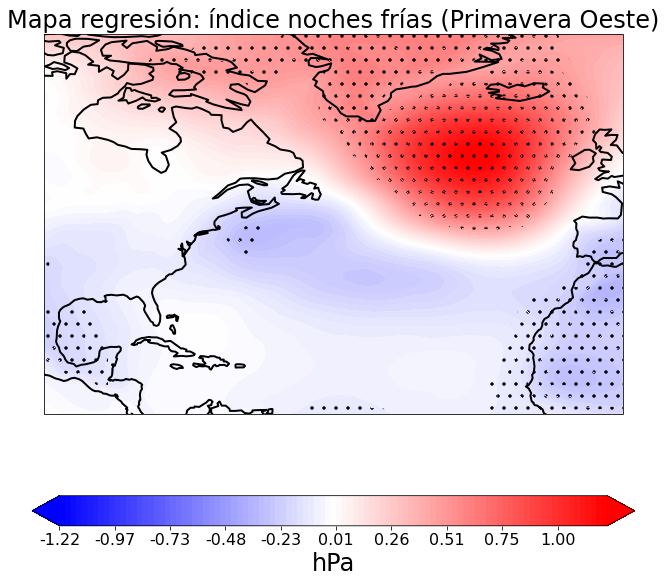

In [160]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

var = regI/100 
var_sig = regI_sig/100
rang = max((abs(var.min()),abs(var.max())))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlat,nlon)),lonAN,latAN,levels,'bwr','hPa','Mapa regresión: índice noches frías (Primavera Oeste)', ax)
ax.contourf(lonAN,latAN,np.reshape(var_sig,(nlat,nlon)),cmap='bwr',levels=levels,hatches='.')

### Selecciono la estación y hago el mapa de regresión con la SST

> De momento voy a tratar de coger el invierno, luego podemos pensar si otros desfases o estaciones exóticas darían mejores resultados.

In [189]:
# reorganizo los datos para que estén en numero de años, numero de meses y espacio
SST=np.reshape(np.array(sst_PA), (nyears,12,len(lonPA)*len(latPA)))
#ahora calculo las medias estacionales, por ejemplo del mes 9 (octubre) al mes 1 (febrero)
SST_sea, ny1=season(SST,9,1,nyears)

In [102]:
SST_sea

array([[26.665264, 26.6348  , 26.614803, ..., 20.745787, 20.425346,
        20.224527],
       [26.416565, 26.409832, 26.389837, ..., 20.136463, 19.81977 ,
        19.620825],
       [26.791142, 26.7327  , 26.712704, ..., 19.917566, 19.607286,
        19.411547],
       ...,
       [27.169598, 27.138083, 27.109539, ..., 19.647583, 19.47015 ,
        19.340832],
       [27.043182, 27.02232 , 26.965546, ..., 20.69674 , 20.642889,
        20.575367],
       [26.96103 , 26.964062, 27.003445, ..., 20.713314, 20.693356,
        20.642778]], dtype=float32)

In [104]:
# Ahora voy a calcular las anomalias

SST_sea_an=anom2(np.transpose(SST_sea),1,'pp')
SST_sea_an.shape

(4400, 109)

In [105]:
SST_sea_an

masked_array(
  data=[[-0.21965599, -0.46835518, -0.09377861, ...,  0.28467751,
          0.15826225,  0.07610893],
        [-0.23031425, -0.45528221, -0.13241386, ...,  0.27296829,
          0.15720558,  0.09894753],
        [-0.23834801, -0.46331406, -0.14044762, ...,  0.25638771,
          0.11239433,  0.15029335],
        ...,
        [ 0.41840172, -0.19092178, -0.40981865, ..., -0.67980194,
          0.36935425,  0.38592911],
        [ 0.24063683, -0.36493874, -0.5774231 , ..., -0.71455956,
          0.45817947,  0.50864601],
        [ 0.15175819, -0.45194435, -0.66122246, ..., -0.73193741,
          0.50259781,  0.57000923]],
  mask=False,
  fill_value=1e+20)

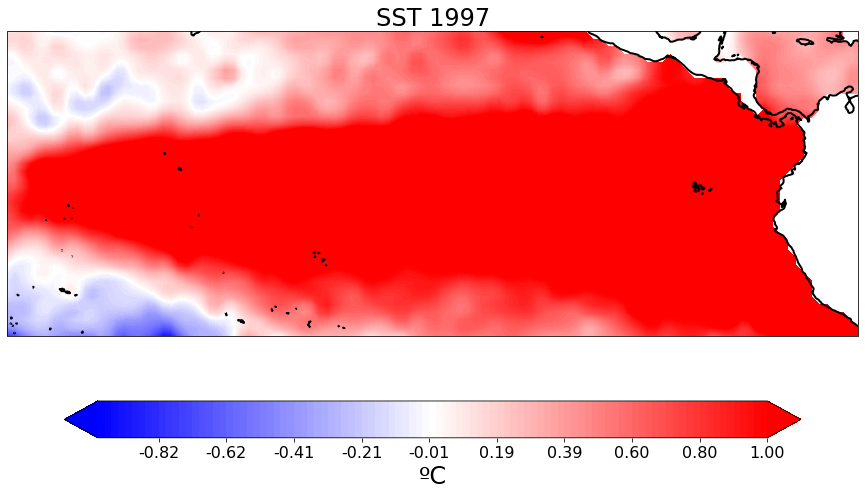

In [106]:
fig = plt.figure(figsize=(22,8)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(SST_sea_an[:,np.where(years==1997)],(len(latsst),len(lonsst))),lonsst,latsst,np.linspace(-1,1,100), 'bwr', 'ºC','SST 1997',ax)

In [107]:
y2 =quitonans(np.transpose(SST_sea_an) )
y2.shape

(109, 4119)

In [119]:
cor2,Pvalue2,cor_sig2,reg2,reg2_sig=IndexRegrCorr(np.transpose(y2),np.transpose(np.array(anomN_O_spring[:-1])),0.01,'MonteCarlo',100)

In [122]:
#reg2 = np.expand_dims(reg2, axis=0)

In [123]:
#reg2.shape

(1, 4119)

In [133]:
mat = np.expand_dims(np.transpose(SST_sea_an)[0], axis=0)

In [ ]:
pongonans(reg2,SST_sea_an)

In [146]:
out = mat.mean(axis = 0 )
print(out.shape)
out[~np.isnan(mat.mean(axis = 0))].shape


(4400,)


(4119,)

In [149]:
reg23 = pongonans(np.squeeze(reg2),mat)


In [156]:
reg23_sig = pongonans(np.squeeze(reg2_sig),mat)

In [343]:
nlatPA = sst_PA.latitude.size
nlonPA = sst_PA.longitude.size
print(nlatPA,nlonPA)

40 110


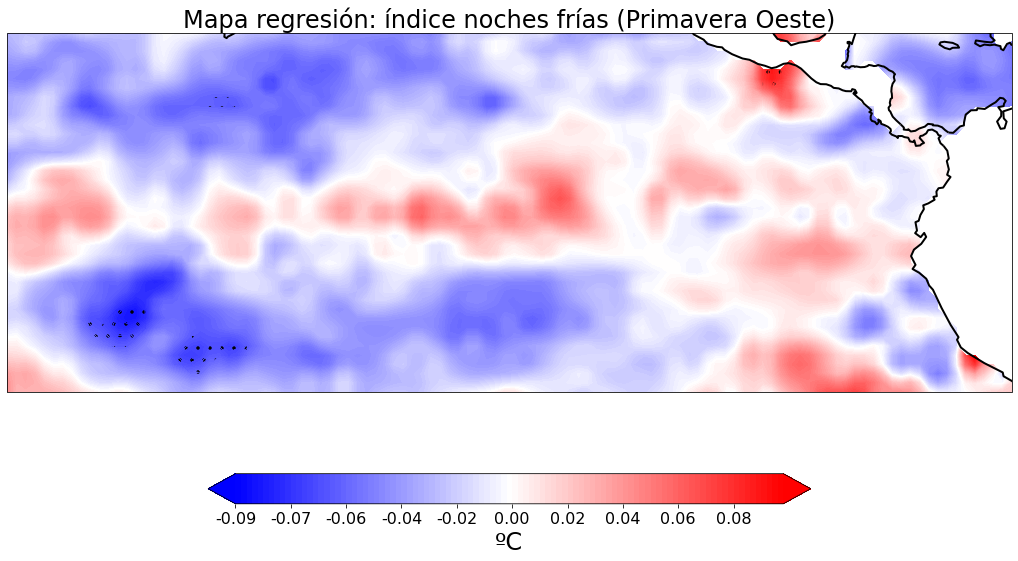

In [162]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = reg23
var_sig = reg23_sig
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlatPA,nlonPA)),lonPA,latPA,levels,'bwr','ºC','Mapa regresión: índice noches frías (Primavera Oeste)', ax)
ax.contourf(lonPA,latPA,np.reshape(var_sig,(nlatPA,nlonPA)),cmap='bwr',levels=levels,hatches='.')

Voy a hacer lo mismo para los días fríos del Oeste:

In [163]:
anom_O_spring = (corr_O_spring-corr_O_spring.mean())/corr_O_spring.std()

In [164]:
corId,PvalueId,cor_sigId,regId,regId_sig=IndexRegression(np.transpose(ATN_spring_ano),np.transpose(np.array(anom_O_spring)),0.05,'MonteCarlo',100)

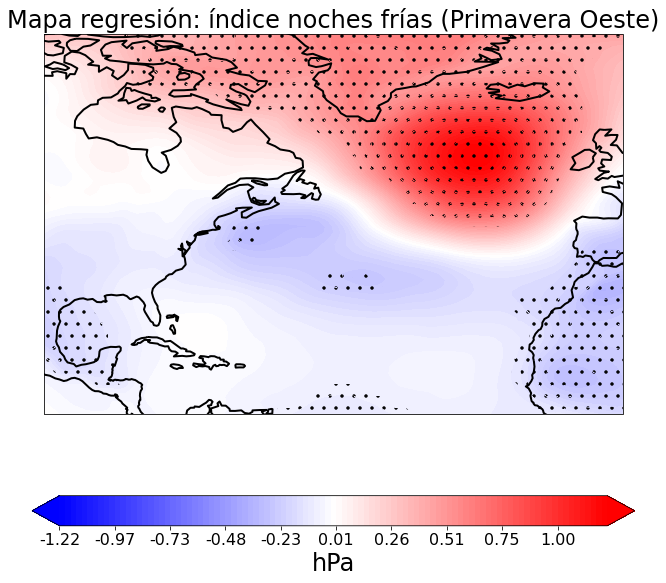

In [165]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

var = regId/100 
var_sig = regId_sig/100
rang = max((abs(var.min()),abs(var.max())))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlat,nlon)),lonAN,latAN,levels,'bwr','hPa','Mapa regresión: índice días fríos (Primavera Oeste)', ax)
ax.contourf(lonAN,latAN,np.reshape(var_sig,(nlat,nlon)),cmap='bwr',levels=levels,hatches='.')

In [166]:
cor2d,Pvalue2d,cor_sig2d,reg2d,reg2d_sig=IndexRegrCorr(np.transpose(y2),np.transpose(np.array(anom_O_spring[:-1])),0.1,'MonteCarlo',100)

In [168]:
reg23d = pongonans(np.squeeze(reg2d),mat)
reg23d_sig = pongonans(np.squeeze(reg2d_sig),mat)

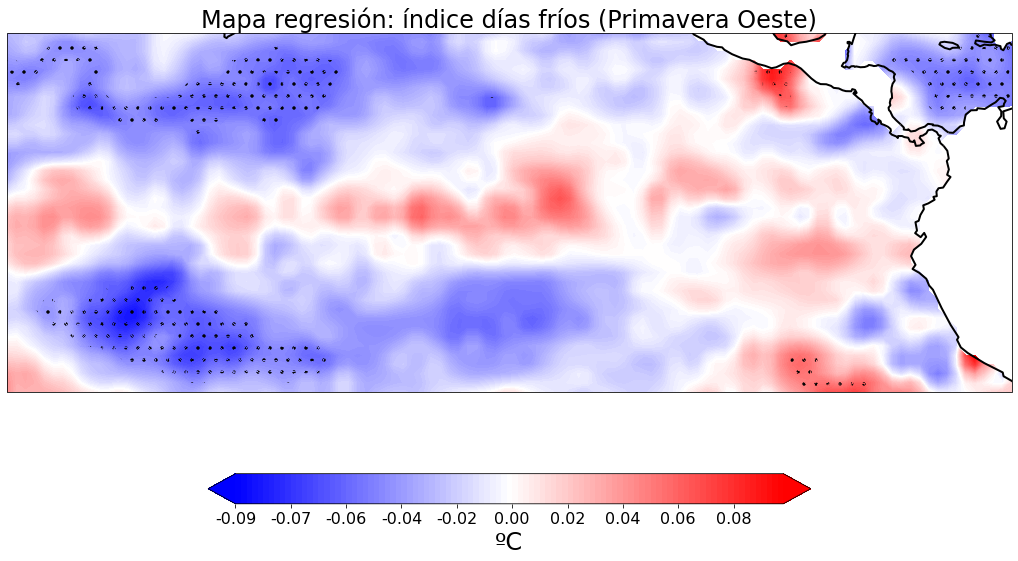

In [169]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = reg23d
var_sig = reg23d_sig
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlatPA,nlonPA)),lonPA,latPA,levels,'bwr','ºC','Mapa regresión: índice días fríos (Primavera Oeste)', ax)
ax.contourf(lonPA,latPA,np.reshape(var_sig,(nlatPA,nlonPA)),cmap='bwr',levels=levels,hatches='.')

Voy a probar con la SST del Atlántico:

In [206]:
# Nota: slp y sst están desplazadas 360 (o algo así en longitud)
sst_A, latA, lonA = region3(sst, latsst, lonsst,260-360, 360-360, 10, 75)
sst_A


<xarray.DataArray 'sst' (time: 1320, latitude: 65, longitude: 100)>
[8580000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -99.5 -98.5 -97.5 -96.5 ... -2.5 -1.5 -0.5
  * latitude   (latitude) float32 74.5 73.5 72.5 71.5 ... 13.5 12.5 11.5 10.5
  * time       (time) datetime64[ns] 1901-01-16T12:00:00 ... 2010-12-16T12:00:00
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [215]:
# reorganizo los datos para que estén en numero de años, numero de meses y espacio
SST_A=np.reshape(np.asarray(sst_A), (nyears,12,len(lonA)*len(latA)))
#ahora calculo las medias estacionales, por ejemplo del mes 9 (octubre) al mes 1 (febrero)
SST_EFM, ny2=season(SST_A,2,5,nyears)

In [216]:
# Ahora voy a calcular las anomalias

SST_EFM_an=anom2(np.transpose(SST_EFM),1,'pp')
SST_EFM_an.shape

(6500, 110)

In [217]:
y3 =quitonans(np.transpose(SST_EFM_an) )
y3.shape

(110, 3967)

In [218]:
corA,PvalueA,cor_sigA,regA,regA_sig=IndexRegrCorr(np.transpose(y3),np.transpose(np.array(anomN_O_spring)),0.05,'MonteCarlo',100)

In [219]:
mat2 = np.expand_dims(np.transpose(SST_EFM_an)[0], axis=0)

In [220]:
regA3 = pongonans(np.squeeze(regA),mat2)
regA3_sig = pongonans(np.squeeze(regA_sig),mat2)


In [221]:
nlatA = sst_A.latitude.size
nlonA = sst_A.longitude.size
print(nlatA,nlonA)

65 100


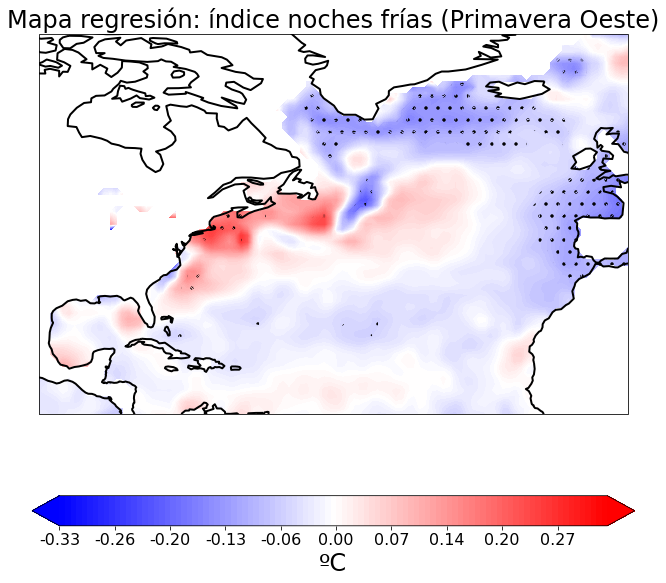

In [222]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = regA3
var_sig = regA3_sig
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlatA,nlonA)),lonA,latA,levels,'bwr','ºC','Mapa regresión: índice noches frías (Primavera Oeste)', ax)
ax.contourf(lonA,latA,np.reshape(var_sig,(nlatA,nlonA)),cmap='bwr',levels=levels,hatches='.')

---

## Voy a intentar hacer todo de nuevo con otra región:

Cargo la matriz mensual con toda España:

In [308]:
Tn10p = xr.load_dataarray('../Practica 2/outs/Tn10p_ESP_nan.nc')
Tx10p = xr.load_dataarray('../Practica 2/outs/Tn10p_ESP_nan.nc')
Tn10p = Tn10p.sel(time=slice(str(minyear),str(maxyear)))
Tx10p = Tx10p.sel(time=slice(str(minyear),str(maxyear)))

# Pongo bien los índices
#Tn10p = Tn10p.assign_coords({"lat":Tn10p.y,"lon":Tn10p.x}) 
Tx10p = Tx10p.set_index(lon="x") 
Tx10p = Tx10p.set_index(lat="y") 
Tn10p = Tn10p.set_index(lon="x") 
Tn10p = Tn10p.set_index(lat="y")
Tn10p

<xarray.DataArray (time: 1320, lat: 190, lon: 230)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2010-12-01
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66

In [309]:
# Defino todas las regiones
oeste = [[43.8,42],[-9,-6]] # lat, lon
sur = [[38,36],[-8, 0]]
centro = [[42,38],[-7, -1]]
norte = [[43.8,42.5],[-6,0]]
este = [[43,36.2],[-2,4]]

Selecciono la estación en la matriz grande:

In [310]:
# La pongo por estaciones
Tn10p_seasons = resample_month_to_season(Tn10p)
Tx10p_seasons = resample_month_to_season(Tx10p)

In [311]:
# Voy a escoger la primavera
Tn10p_spring = Tn10p_seasons.sel(time=(Tn10p_seasons.time.dt.month==3))
Tx10p_spring = Tx10p_seasons.sel(time=(Tx10p_seasons.time.dt.month==3))
Tn10p_spring

<xarray.DataArray (time: 110, lat: 190, lon: 230)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * time     (time) datetime64[ns] 1901-03-01 1902-03-01 ... 2010-03-01

Ahora selecciono la región (Sur):

In [328]:
Tn10p_spring_S = Tn10p_spring.sel(lat=slice(sur[0][0],sur[0][1]),lon=slice(sur[1][0],sur[1][1]))
Tx10p_spring_S = Tx10p_spring.sel(lat=slice(sur[0][0],sur[0][1]),lon=slice(sur[1][0],sur[1][1]))
Tn10p_spring_S

<xarray.DataArray (time: 110, lat: 44, lon: 137)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lon      (lon) float64 -7.976 -7.918 -7.859 ... -0.1371 -0.07858 -0.02008
  * lat      (lat) float64 37.96 37.91 37.87 37.82 ... 36.16 36.11 36.07 36.02
  * time     (time) datetime64[ns] 1901-03-01 1902-03-01 ... 2010-03-01

Cuidado aquí que parece que al pasar los datos a estaciones los nan se volvieron a convertir en ceros...
En vez de `Tn10p_spring_S.mean(dim=['lat','lon'])` para hallar las series temporales habrá que usar `correct_series(Tn10p_spring_S,freq='YS')`

In [329]:
correct_series(Tn10p_spring_S,freq='YS')


<xarray.DataArray (time: 110)>
array([ 5.86177663,  7.4439635 ,  6.61409942,  5.32649623,  2.06225359,
       10.40707452,  8.32173086, 10.62795225,  2.78941854,  9.95974746,
       12.63957432,  2.55302615,  4.92094235,  5.64569491, 14.28379422,
        9.44053078, 19.88365361, 10.74377602,  5.26901657,  5.02086731,
        3.71336605, 10.5855918 ,  7.41949491,  4.02402928, 23.71936258,
        8.72735794,  1.31199857,  6.14686142,  9.1881255 , 11.50540377,
        7.10622812, 14.18623794,  0.29741391, 12.66438753,  6.92977861,
        2.66560622,  3.61962725,  5.33484051, 10.24475476,  2.86361566,
       11.14251055,  1.01458465,  0.09856359,  6.63649469,  1.61354801,
        3.07166883,  2.64191779,  0.99228367,  3.47660666,  3.59240164,
       10.94021395,  2.42960189,  4.78860522,  5.69704447,  8.17733175,
        6.6297211 ,  5.25419757, 10.71448264,  1.41297455,  1.56879865,
        0.36427173,  2.73875824,  3.2329547 ,  3.06500562,  2.11877257,
        3.23433321,  3.09579278,  5.69215114,  3.99458245, 14.29620082,
       15.52721182, 16.22626975, 14.56983541, 16.53249152, 20.87514819,
        8.78830271,  8.71632985,  8.23074908, 10.26405393,  8.15800599,
        5.47200243,  3.20400596,  9.23568416, 26.07328967, 13.4646136 ,
       18.05264536,  3.11302418,  3.66351044,  5.87556174,  4.54667641,
       11.79247884,  4.68917328, 11.7056326 ,  7.22546938,  6.70990599,
        4.07357461,  0.49350721,  5.85591795,  2.32968487,  2.56642511,
        3.69234375,  3.1774696 ,  0.96978302, 10.44693437,  9.17606352,
        1.80516115,  5.83627416,  5.24488051,  3.00308787,  6.98354057])
Coordinates:
  * time     (time) datetime64[ns] 1901-03-01 1902-03-01 ... 2010-03-01

In [330]:
Tn10p_spring_S.mean(dim=['lat','lon'])

<xarray.DataArray (time: 110)>
array([ 3.06702778,  3.89486743,  3.46066184,  2.78695572,  1.07902253,
        5.44524105,  4.35413721,  5.56080979,  1.45949338,  5.21118837,
        6.61334064,  1.33580698,  2.57475982,  2.95396844,  7.47363752,
        4.93952125, 10.40362367,  5.62141167,  2.75688093,  2.62704305,
        1.94292577,  5.53864574,  3.88206486,  2.10547252, 12.4105623 ,
        4.56637143,  0.68647038,  3.21619126,  4.80745651,  6.01991431,
        3.71815585,  7.42259364,  0.15561438,  6.62632353,  3.62583307,
        1.39471168,  1.89387929,  2.79132166,  5.3603113 ,  1.49831516,
        5.83003953,  0.53085601,  0.05157093,  3.4723796 ,  0.84424858,
        1.60717377,  1.3823173 ,  0.51918758,  1.81904734,  1.87963417,
        5.7241929 ,  1.27122833,  2.50551773,  2.98083581,  4.278584  ,
        3.46883549,  2.74912726,  5.60608465,  0.73930354,  0.8208346 ,
        0.19059606,  1.43298664,  1.69156256,  1.60368741,  1.10859467,
        1.69228383,  1.61979602,  2.9782755 ,  2.0900652 ,  7.48012896,
        8.12422463,  8.48998918,  7.62330141,  8.65021205, 10.92239837,
        4.59825925,  4.56060125,  4.30653328,  5.37040911,  4.26847228,
        2.8630882 ,  1.67641586,  4.83234038, 13.64219569,  7.04502178,
        9.44559447,  1.62881192,  1.91684007,  3.0742405 ,  2.37893454,
        6.17011915,  2.45349245,  6.12467903,  3.78054586,  3.51079023,
        2.13139587,  0.25821529,  3.06396238,  1.21894925,  1.34281765,
        1.93192637,  1.66253138,  0.50741467,  5.46609672,  4.80114538,
        0.94450535,  3.05368426,  2.74425235,  1.5712905 ,  3.65396267])
Coordinates:
  * time     (time) datetime64[ns] 1901-03-01 1902-03-01 ... 2010-03-01

In [332]:
Tn10p_spring_Sm = correct_series(Tn10p_spring_S,freq='YS')
Tx10p_spring_Sm = correct_series(Tx10p_spring_S,freq='YS')

In [346]:
anomN_S_spring = (Tn10p_spring_Sm-Tn10p_spring_Sm.mean())/Tn10p_spring_Sm.std()
anomD_S_spring = (Tx10p_spring_Sm-Tx10p_spring_Sm.mean())/Tx10p_spring_Sm.std()


In [347]:
anomN_S_spring

<xarray.DataArray (time: 110)>
array([-0.23004799,  0.07944081, -0.08288745, -0.33475325, -0.97326603,
        0.65904976,  0.25113934,  0.70225526, -0.83102657,  0.5715489 ,
        1.09574513, -0.87726687, -0.41408293, -0.27231536,  1.4173681 ,
        0.46998583,  2.51274677,  0.72491135, -0.34599675, -0.39453679,
       -0.65029482,  0.69396921,  0.07465455, -0.58952653,  3.26304308,
        0.33048334, -1.1200221 , -0.17428306,  0.42061328,  0.87389202,
        0.01337698,  1.39828529, -1.31848322,  1.1005988 , -0.021138  ,
       -0.85524528, -0.6686309 , -0.33312104,  0.62729868, -0.816513  ,
        0.80290711, -1.17819871, -1.35737999, -0.07850675, -1.06103654,
       -0.77581608, -0.85987893, -1.18256097, -0.69660691, -0.67395645,
        0.76333623, -0.90140967, -0.43996917, -0.26227096,  0.22289369,
       -0.07983172, -0.34889547,  0.71918132, -1.10027036, -1.06978988,
       -1.30540528, -0.84093614, -0.74426724, -0.77711946, -0.96221045,
       -0.74399759, -0.77109724, -0.26322813, -0.59528657,  1.41979493,
        1.66059084,  1.79733233,  1.47332011,  1.85723183,  2.70669129,
        0.34240464,  0.32832616,  0.23334256,  0.63107375,  0.21911341,
       -0.30629104, -0.74992985,  0.42991614,  3.72349063,  1.25712962,
        2.15458646, -0.76772664, -0.66004698, -0.22735151, -0.48729244,
        0.93004627, -0.45941888,  0.91305843,  0.03670156, -0.06414689,
       -0.57983505, -1.28012576, -0.231194  , -0.92095426, -0.87464592,
       -0.65440695, -0.75512058, -1.18696228,  0.66684667,  0.41825386,
       -1.02355543, -0.23503648, -0.35071796, -0.78923109, -0.01062171])
Coordinates:
  * time     (time) datetime64[ns] 1901-03-01 1902-03-01 ... 2010-03-01

In [348]:
corIS,PvalueIS,cor_sigIS,regIS,regIS_sig=IndexRegression(np.transpose(ATN_spring_ano),np.transpose(np.array(anomN_S_spring)),0.05,'MonteCarlo',100)

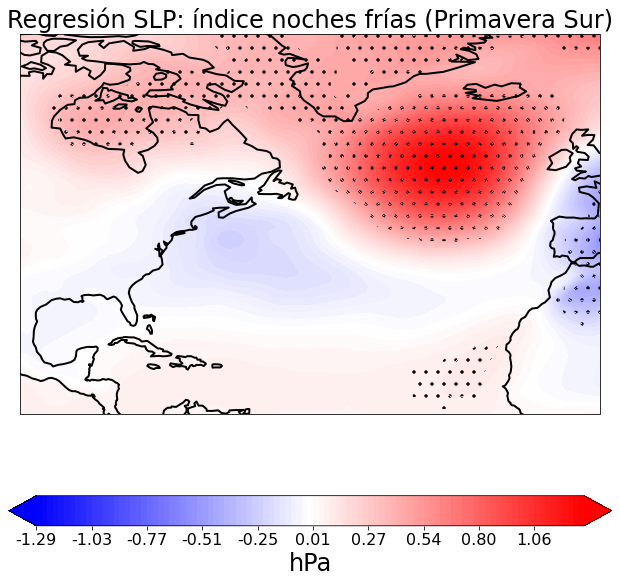

In [349]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

var = regIS/100 
var_sig = regIS_sig/100
rang = max((abs(var.min()),abs(var.max())))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlat,nlon)),lonAN,latAN,levels,'bwr','hPa','Regresión SLP: índice noches frías (Primavera Sur)', ax)
ax.contourf(lonAN,latAN,np.reshape(var_sig,(nlat,nlon)),cmap='bwr',levels=levels,hatches='.')

In [350]:
corDS,PvalueDS,cor_sigDS,regDS,regDS_sig=IndexRegression(np.transpose(ATN_spring_ano),np.transpose(np.array(anomD_S_spring)),0.05,'MonteCarlo',100)

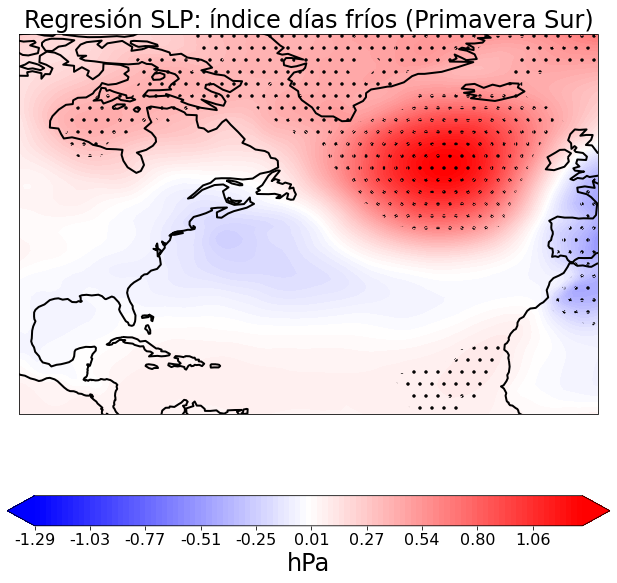

In [351]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

var = regDS/100 
var_sig = regDS_sig/100
rang = max((abs(var.min()),abs(var.max())))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlat,nlon)),lonAN,latAN,levels,'bwr','hPa','Regresión SLP: índice días fríos (Primavera Sur)', ax)
ax.contourf(lonAN,latAN,np.reshape(var_sig,(nlat,nlon)),cmap='bwr',levels=levels,hatches='.')

In [352]:
corPSN,PvaluePSN,cor_sigPSN,regPSN,regPSN_sig=IndexRegrCorr(np.transpose(y2),np.transpose(np.array(anomN_S_spring[:-1])),0.05,'MonteCarlo',100)

In [353]:
regPSN_n = pongonans(np.squeeze(regPSN),mat)
regPSN_n_sig = pongonans(np.squeeze(regPSN_sig),mat)

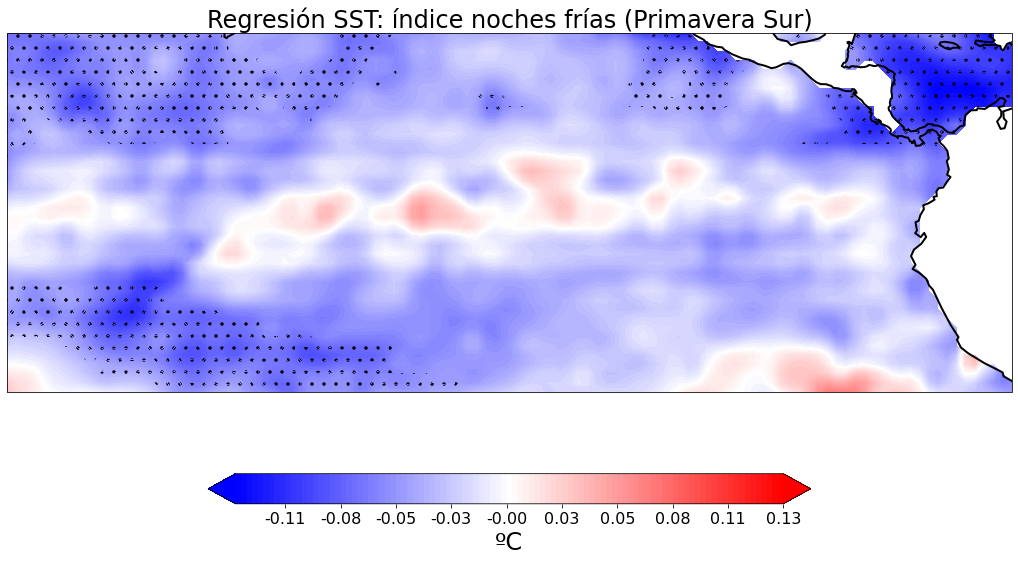

In [354]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = regPSN_n
var_sig = regPSN_n_sig
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlatPA,nlonPA)),lonPA,latPA,levels,'bwr','ºC','Regresión SST: índice noches frías (Primavera Sur)', ax)
ax.contourf(lonPA,latPA,np.reshape(var_sig,(nlatPA,nlonPA)),cmap='bwr',levels=levels,hatches='.')

In [355]:
corPSD,PvaluePSD,cor_sigPSD,regPSD,regPSD_sig=IndexRegrCorr(np.transpose(y2),np.transpose(np.array(anomD_S_spring[:-1])),0.05,'MonteCarlo',100)
regPSD_n = pongonans(np.squeeze(regPSD),mat)
regPSD_n_sig = pongonans(np.squeeze(regPSD_sig),mat)

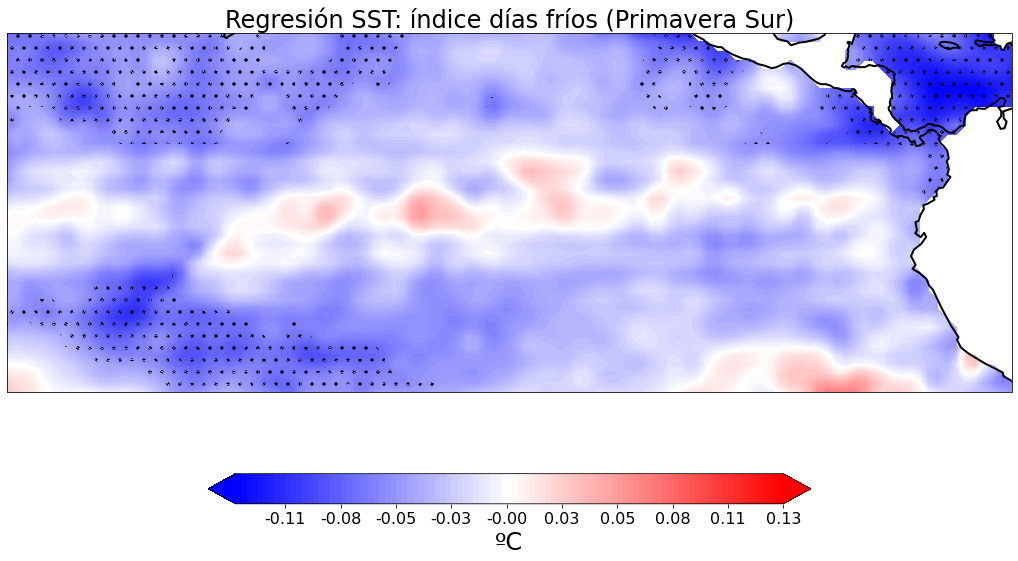

In [360]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = regPSD_n
var_sig = regPSD_n_sig
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlatPA,nlonPA)),lonPA,latPA,levels,'bwr','ºC','Regresión SST: índice días fríos (Primavera Sur)', ax)
ax.contourf(lonPA,latPA,np.reshape(var_sig,(nlatPA,nlonPA)),cmap='bwr',levels=levels,hatches='.')

Ahora el Atlántico:

In [363]:
corASN,PvalueASN,cor_sigASN,regASN,regASN_sig=IndexRegrCorr(np.transpose(y3),np.transpose(np.array(anomN_S_spring)),0.05,'MonteCarlo',100)

In [364]:
regASN_n = pongonans(np.squeeze(regASN),mat2)
regASN_n_sig = pongonans(np.squeeze(regASN_sig),mat2)

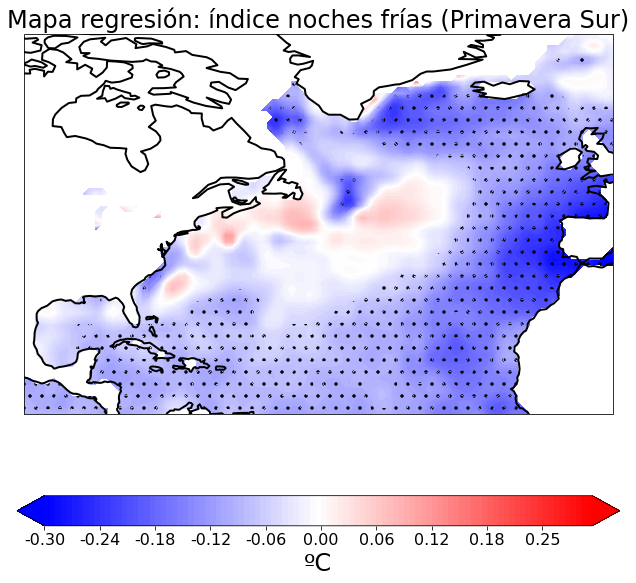

In [365]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = regASN_n
var_sig = regASN_n_sig
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
levels = np.linspace(-rang,rang,100)

dibujo_1_mapa_cartopy(np.reshape(var,(nlatA,nlonA)),lonA,latA,levels,'bwr','ºC','Mapa regresión: índice noches frías (Primavera Sur)', ax)
ax.contourf(lonA,latA,np.reshape(var_sig,(nlatA,nlonA)),cmap='bwr',levels=levels,hatches='.')

---

## Remallado de la matriz de extremos:

In [366]:
Tn10p_regrid = Tn10p.interp(lat=Tn10p.lat[::2]).interp(lon=Tn10p.lon[::2])

In [367]:
Tn10p

<xarray.DataArray (time: 1320, lat: 190, lon: 230)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2010-12-01
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66

In [368]:
Tn10p_regrid

<xarray.DataArray (time: 1320, lat: 95, lon: 115)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2010-12-01
  * lat      (lat) float64 44.17 44.08 43.99 43.9 ... 35.98 35.89 35.8 35.71
  * lon      (lon) float64 -9.673 -9.556 -9.439 -9.322 ... 3.431 3.548 3.665

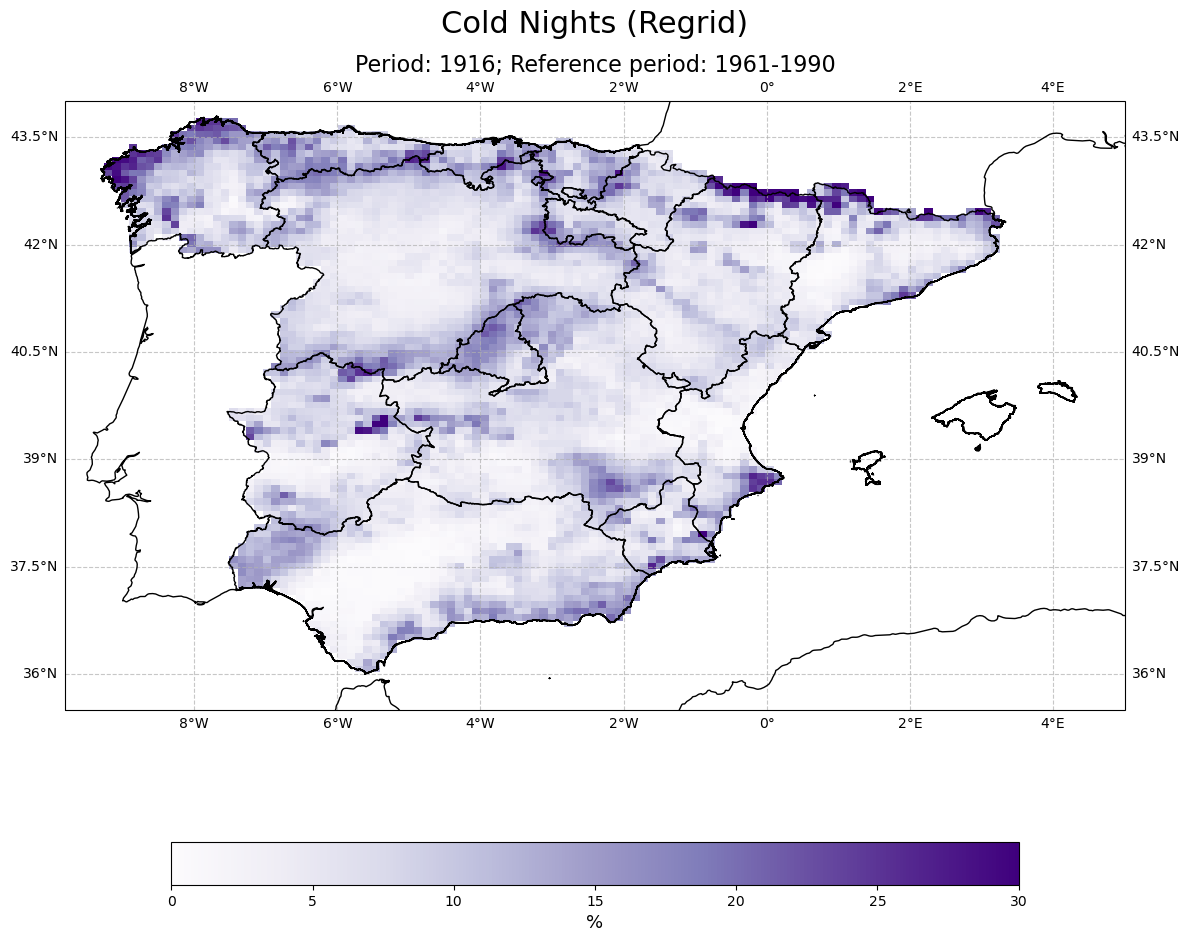

In [380]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = '../Practica 2/mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Nights (Regrid)',size=22)
plt.title('Period: 1916; Reference period: 1961-1990',size=16)

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot


# A partir de aquí vamos a pintar los valores promedio de días fríos en el periodo empleado  
cmap = 'Purples'

var = Tn10p_regrid.sel(time='1916').mean('time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=30, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 


# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 30)


plt.tight_layout()

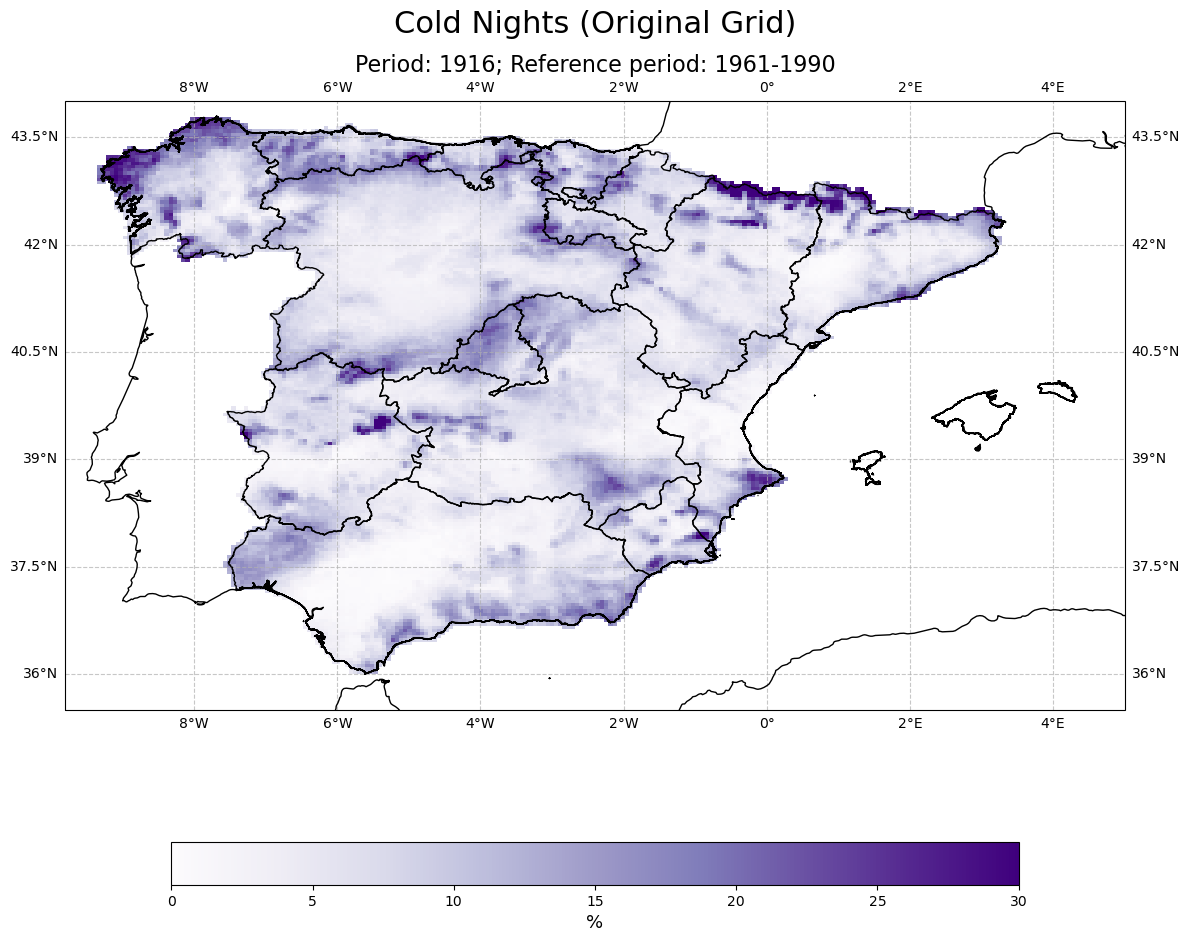

In [379]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = '../Practica 2/mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Nights (Original Grid)',size=22)
plt.title('Period: 1916; Reference period: 1961-1990',size=16)

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot


# A partir de aquí vamos a pintar los valores promedio de días fríos en el periodo empleado  
cmap = 'Purples'

var = Tn10p.sel(time='1916').mean('time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=30, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 


# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 30)


plt.tight_layout()

In [378]:
print('ns (original):'+str(Tn10p.lat.size*Tn10p.lon.size))
print('ns (regrid):'+str(Tn10p_regrid.lat.size*Tn10p_regrid.lon.size))

ns (original):43700
ns (regrid):10925
